In [1]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_validate, GroupKFold
import statsmodels.api as sm


from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo_v1
from M1_util_train_test import load_model, test
import linear_reg
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir


In [2]:
data_version = '1571'

model_type = 'AE'
sampling = 's'

zoomlevel = 'zoom15'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']


# Load Model Embeddings

In [3]:
# 0.5
with open(proj_dir+"latent_space/2023-06-27T20-57-11_sae_kl_f32_ep62.pkl", "rb") as f:
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)
    sup_true_list = pkl.load(f)
    sup_list = pkl.load(f)

In [4]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
#     aggregate_embeddings.append(np.mean(sup_list[ct == i], axis=0))
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

x = aggregate_embeddings

x = x.reshape(x.shape[0],-1)

In [5]:
print(x.shape)

(1588, 4096)


# Load Trip Behavior

In [6]:
file = "MyDailyTravel/origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, data_version)
y_ct = df_pivot['geoid'].to_list()
y = df_pivot[variable_names].to_numpy()[:,:4]

groups = df_pivot['train_test']
group_split = GroupKFold(n_splits=5)

In [7]:
if len(x) != len(y):
    x_mask = [True if c in y_ct else False for c in unique_ct]
    x = x[x_mask,:]
    unique_ct = list(np.array(unique_ct)[x_mask])
    y_mask = [True if c in unique_ct else False for c in y_ct]
    y = y[y_mask,:]
    y_ct = list(np.array(y_ct)[y_mask])

x = x[[y_ct.index(val) for val in unique_ct],:]
unique_ct = list(np.array(unique_ct)[np.array([y_ct.index(val) for val in unique_ct])])
for xc,yc in zip(unique_ct, y_ct):
    assert xc == yc

In [8]:
print(len(y))

1571


# 1. Linear Regression

### 1.1 Auto Share

In [10]:
y_index = 1

In [11]:
# Lasso
for a in (1e-3)*np.array([2,3,4,5,6]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0182342529296875, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.561030387878418, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.784701347351074, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/si

Parameter: 2.00e-03 	 Train score: 0.7810 	 Cross val score: 0.6123 	 Nonzero coef: 364


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.33841609954834, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0145788192749023, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.105973243713379, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/sit

Parameter: 3.00e-03 	 Train score: 0.7286 	 Cross val score: 0.6252 	 Nonzero coef: 204


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5568408966064453, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7776193618774414, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4423046112060547, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/

Parameter: 4.00e-03 	 Train score: 0.7026 	 Cross val score: 0.6310 	 Nonzero coef: 136


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.421116828918457, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5078010559082031, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7546520233154297, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/s

Parameter: 5.00e-03 	 Train score: 0.6883 	 Cross val score: 0.6325 	 Nonzero coef: 102


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4821510314941406, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4259929656982422, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2590217590332031, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/

Parameter: 6.00e-03 	 Train score: 0.6796 	 Cross val score: 0.6316 	 Nonzero coef: 82


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45783233642578125, tolerance: 0.00676005519926548
  model = cd_fast.enet_coordinate_descent(


### 1.2 PT

In [11]:
y_index = 3

In [12]:
# Lasso
for a in (1e-3)*np.array([2,3,4,5,6]):
# for a in (1e-4)*np.array([10,15,20,25,30,50]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.33841609954834, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0145788192749023, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.105973243713379, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/sit

Parameter: 3.00e-03 	 Train score: 0.7286 	 Cross val score: 0.6252 	 Nonzero coef: 204


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5568408966064453, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7776193618774414, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4423046112060547, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/

Parameter: 4.00e-03 	 Train score: 0.7026 	 Cross val score: 0.6310 	 Nonzero coef: 136


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.421116828918457, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5078010559082031, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7546520233154297, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/s

Parameter: 5.00e-03 	 Train score: 0.6883 	 Cross val score: 0.6325 	 Nonzero coef: 102


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4821510314941406, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4259929656982422, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2590217590332031, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/

Parameter: 6.00e-03 	 Train score: 0.6796 	 Cross val score: 0.6316 	 Nonzero coef: 82


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3138885498046875, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20669174194335938, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20465660095214844, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.

Parameter: 7.00e-03 	 Train score: 0.6734 	 Cross val score: 0.6304 	 Nonzero coef: 73


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24727630615234375, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4731731414794922, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1725635528564453, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8

Parameter: 8.00e-03 	 Train score: 0.6688 	 Cross val score: 0.6290 	 Nonzero coef: 67


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.197509765625, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31686973571777344, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10542488098144531, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/si

Parameter: 9.00e-03 	 Train score: 0.6650 	 Cross val score: 0.6277 	 Nonzero coef: 62


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18309593200683594, tolerance: 0.00676005519926548
  model = cd_fast.enet_coordinate_descent(


### 1.3 Active

In [13]:
y_index = 0

In [14]:
# Lasso
for a in (1e-3)*np.array([2,3,4,5,6]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.063737392425537, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.850252628326416, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.208263874053955, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/s

Parameter: 2.00e-03 	 Train score: 0.6710 	 Cross val score: 0.5105 	 Nonzero coef: 243


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4185361862182617, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4945216178894043, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2344226837158203, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.

Parameter: 3.00e-03 	 Train score: 0.6166 	 Cross val score: 0.5255 	 Nonzero coef: 135


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0901603698730469, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6388053894042969, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1287059783935547, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.

Parameter: 4.00e-03 	 Train score: 0.5941 	 Cross val score: 0.5278 	 Nonzero coef: 89


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27818965911865234, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0691061019897461, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05237007141113281, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python

Parameter: 5.00e-03 	 Train score: 0.5821 	 Cross val score: 0.5281 	 Nonzero coef: 71


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12719345092773438, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05658149719238281, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09978961944580078, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/pytho

Parameter: 6.00e-03 	 Train score: 0.5738 	 Cross val score: 0.5273 	 Nonzero coef: 60


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26412010192871094, tolerance: 0.003289309563115239
  model = cd_fast.enet_coordinate_descent(


# 2. MNL for Mode Share

In [19]:
from util_aggregate_models import mnl_torch

# dataloader and model definition

lr_list = [1e-5]
wd_list = [1, 1e-1, 1e-2, 1e-3]

results = {}

for i in range(5):
    
    train_filter = groups != i
    test_filter = groups == i
    x_train = x[train_filter]
    y_train = y[train_filter]
    x_test = x[test_filter]
    y_test = y[test_filter]
    sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
    sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)
    
    trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

    testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    ret_dict = mnl_torch(trainloader, testloader, x_train.shape[-1], 
                         sst_train, sst_test, lr_list=lr_list, wd_list=wd_list,
                         save_models=True,
                         save_name='SAE+(4096)_0.5_'+str(i))
    
    results[i] = ret_dict
    

[lr: 1.00e-05, wd: 1.00e+00]
[epoch: 3990] Train KL loss: 0.118 Train R2 score: 0.568 0.679 0.083 0.560 
[epoch: 3990] Test KL loss: 0.143 Test R2 score: 0.477 0.583 -0.052 0.440 

[lr: 1.00e-05, wd: 1.00e-01]
[epoch: 3990] Train KL loss: 0.111 Train R2 score: 0.641 0.696 0.136 0.494 
[epoch: 3990] Test KL loss: 0.145 Test R2 score: 0.449 0.575 -0.047 0.415 

[lr: 1.00e-05, wd: 1.00e-02]
[epoch: 3990] Train KL loss: 0.109 Train R2 score: 0.590 0.703 0.202 0.615 
[epoch: 3990] Test KL loss: 0.142 Test R2 score: 0.418 0.586 -0.047 0.494 

[lr: 1.00e-05, wd: 1.00e-03]
[epoch: 3990] Train KL loss: 0.114 Train R2 score: 0.622 0.692 0.140 0.477 
[epoch: 3990] Test KL loss: 0.141 Test R2 score: 0.447 0.609 -0.049 0.417 

[lr: 1.00e-05, wd: 1.00e+00]
[epoch: 3990] Train KL loss: 0.101 Train R2 score: 0.695 0.733 0.214 0.568 
[epoch: 3990] Test KL loss: 0.149 Test R2 score: 0.440 0.596 -0.129 0.441 

[lr: 1.00e-05, wd: 1.00e-01]
[epoch: 3990] Train KL loss: 0.106 Train R2 score: 0.656 0.719 0.0

In [20]:
df = []

for (lr, wd) in itertools.product(lr_list, wd_list):

    new = []
    
    for i in range(5):
        new2 = []
        for k,v in results[i][(lr,wd)].items():
            if k != 'train_loss' and k != 'test_loss':
                new2.append(results[i][(lr,wd)][k]) 
        new.append(new2)
        
    new = np.array(new) 
    
    df.append([lr] + [wd] + list(np.mean(new, axis=0)))

pd.DataFrame(np.array(df), columns = ['learning_rate','weight_decay','train_kl_loss','test_kl_loss','train_r2_auto','train_r2_active','train_r2_pt',
                                     'test_r2_auto','test_r2_active','test_r2_pt']).sort_values(by='test_kl_loss').round(5)


,learning_rate,weight_decay,train_kl_loss,test_kl_loss,train_r2_auto,train_r2_active,train_r2_pt,test_r2_auto,test_r2_active,test_r2_pt
1,0.00001,0.100,0.10999,0.14056,0.70633,0.62970,0.60811,0.60513,0.47200,0.42108
0,0.00001,1.000,0.10772,0.14087,0.71665,0.64273,0.58864,0.60205,0.47644,0.43094
2,0.00001,0.010,0.10793,0.14201,0.71097,0.61714,0.60054,0.60614,0.45691,0.41344
3,0.00001,0.001,0.11571,0.14264,0.68190,0.59915,0.56960,0.59373,0.45985,0.39526


(0.1, 0.2)

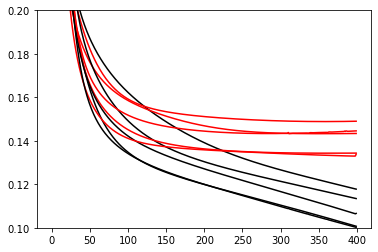

In [21]:
lr = 0.00001
wd = 1
for i in range(5):
    plt.plot(results[i][(lr, wd)]['train_loss'], c='black')
    plt.plot(results[i][(lr, wd)]['test_loss'], c='red')
plt.ylim([0.1,0.2])